In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!pip install --quiet tensorflow_io

     |████████████████████████████████| 24.1MB 56.8MB/s 
     |████████████████████████████████| 2.5MB 39.2MB/s 


In [ ]:
import tensorflow_io as tfio
import numpy as np

# Fichiers tests

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
fichier_test = 'drive/MyDrive/Birds/data_10s/test/Hirundo-rustica-157282_tens.ogg'
fichier_court = 'drive/MyDrive/230420191717.wav'

# Charger modèle

In [ ]:
new_model = tf.keras.models.load_model('drive/MyDrive/Birds/models/model_densenet169_v4')

# Preprocess test file to spectro

In [ ]:
TARGET_SAMPLE_RATE = 16_000
TARGET_SPLIT_DURATION_SEC = 10 

def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)


def generate_mel_spectrogram_prediction(file_path, 
                                    split=True, output_rate=TARGET_SAMPLE_RATE,
                                    transpose=True,
                                    nfft=400, window=400, stride=100,                      # spectrogram params
                                    rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000): # mel spectrogram params
    '''
    Objective : Generate spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y)
    '''
    # 1 - Generate tensor from file path
    ## a) create AudioTensor
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype='float32')

    ## b) convert AudioTensor to tf Tensor and get rate
    tensor = audio_tensor.to_tensor()
    input_rate = tf.cast(audio_tensor.rate, tf.int64)

    ## c) resample to output_rate
    output_rate = np.int64(output_rate)
    tensor = tfio.audio.resample(tensor, input_rate, output_rate, name=None)

    ## d) split if too long
    if split==True:
      split_index = output_rate * TARGET_SPLIT_DURATION_SEC
      tensor = tensor[:split_index]

    ## e) harmonize tensor shape
    if tensor.dtype == tf.int16:
        tensor = tf.cast(tensor, tf.float32)
    
    ## f) convert stereo to mono and remove last dimension
    tensor = tf.reduce_mean(tensor, 1)

    ## d) pad if too short
    tensor = pad_up_to(tensor, (TARGET_SAMPLE_RATE*TARGET_SPLIT_DURATION_SEC,),0)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)

    # 3 - Transpose output if asked
    if transpose == True:
        mel_spectrogram = tf.transpose(mel_spectrogram, perm=[1, 0])
    
    # 4 - Expand dim to get channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)

    # 5 - Convert gray to RGB (requested shape for densenet)
    mel_spectrogram = tf.image.grayscale_to_rgb(mel_spectrogram)

    # 6 - Expand dim to have similar shape as model was trained in batches
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=0)
    print(mel_spectrogram.shape)

    return mel_spectrogram

In [ ]:
spectrogram = generate_mel_spectrogram_prediction(fichier_test)

(1, 128, 1600, 3)


In [ ]:
spectrogram2 = generate_mel_spectrogram_prediction(fichier_court)

(1, 128, 1600, 3)


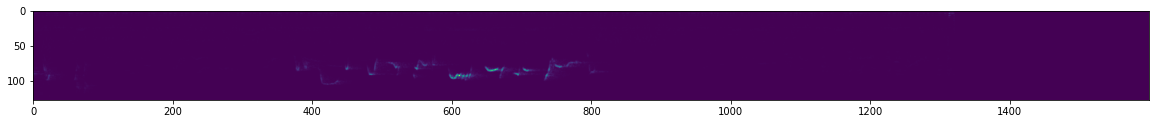

In [ ]:
plt.figure(figsize=(20, 16))
plt.imshow(spectrogram2[0,:,:,0])

In [ ]:
TARGET_DICT = {'Sonus naturalis': 0,
               'Fringilla coelebs': 1,
               'Parus major': 2,
               'Turdus merula': 3,
               'Turdus philomelos': 4,
               'Sylvia communis': 5,
               'Emberiza citrinella': 6,
               'Sylvia atricapilla': 7,
               'Emberiza calandra': 8,
               'Phylloscopus trochilus': 9,
               'Luscinia megarhynchos': 10,
               'Strix aluco': 11,
               'Phylloscopus collybita': 12,
               'Carduelis carduelis': 13,
               'Erithacus rubecula': 14,
               'Chloris chloris': 15,
               'Sylvia borin': 16,
               'Acrocephalus arundinaceus': 17,
               'Acrocephalus dumetorum': 18,
               'Oriolus oriolus': 19,
               'Troglodytes troglodytes': 20,
               'Bubo bubo': 21,
               'Ficedula parva': 22,
               'Linaria cannabina': 23,
               'Luscinia svecica': 24,
               'Alauda arvensis': 25,
               'Luscinia luscinia': 26,
               'Phoenicurus phoenicurus': 27,
               'Aegolius funereus': 28,
               'Cyanistes caeruleus': 29,
               'Hirundo rustica': 30,
               'Emberiza cirlus': 31,
               'Locustella naevia': 32,
               'Cuculus canorus': 33,
               'Sylvia curruca': 34,
               'Loxia curvirostra': 35,
               'Emberiza hortulana': 36,
               'Carpodacus erythrinus': 37,
               'Athene noctua': 38,
               'Crex crex': 39,
               'Acrocephalus schoenobaenus': 40,
               'Acrocephalus palustris': 41,
               'Periparus ater': 42,
               'Phylloscopus sibilatrix': 43,
               'Emberiza schoeniclus': 44,
               'Hippolais icterina': 45,
               'Pyrrhula pyrrhula': 46,
               'Caprimulgus europaeus': 47,
               'Ficedula hypoleuca': 48,
               'Glaucidium passerinum': 49}

REVERSE_DICT = {value : key for (key, value) in TARGET_DICT.items()}

In [ ]:
def get_top_predictions_dict(spectrogram, model):
    '''
    Objective : Generate dictionnary with top 3 predictions from model
    Input : spectrogram, model
    Ouput : dict
    '''
    # Get prediction array (len : 50 -> number of classes)
    prediction = model.predict(spectrogram)[0]
    # Retrieve top 3 predictions with associated values
    top3_pred_indexes = np.argpartition(prediction, -3)[-3:]
    top3_pred_values = prediction[top3_pred_indexes]

    # Convert target number back into scientific name
    top3_pred_names = [REVERSE_DICT[k] for k in top3_pred_indexes]

    # Associate result in a dictionnary for API output
    dico_top3 = dict(zip(top3_pred_names,top3_pred_values))
    
    return dico_top3

In [ ]:
get_top_predictions_dict(spectrogram, new_model)

{'Hirundo rustica': 1.0,
 'Linaria cannabina': 2.9226825e-08,
 'Sylvia atricapilla': 2.4457578e-09}

In [ ]:
get_top_predictions_dict(spectrogram2, new_model)

{'Acrocephalus arundinaceus': 0.0,
 'Erithacus rubecula': 0.0,
 'Luscinia luscinia': 1.0}